<a href="https://colab.research.google.com/github/sophie826/sentiment_analysis/blob/main/data_prep_dashboard.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
from textblob import TextBlob, Word

In [2]:

import seaborn as sns
import matplotlib.pyplot as plt
import csv
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelBinarizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud,STOPWORDS
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize,sent_tokenize
from bs4 import BeautifulSoup
import spacy
import re,string,unicodedata
from nltk.tokenize.toktok import ToktokTokenizer
from nltk.corpus.reader.twitter import TweetTokenizer
from nltk.stem import LancasterStemmer,WordNetLemmatizer
from nltk.corpus import stopwords
from sklearn.linear_model import LogisticRegression,SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from collections import Counter
from wordcloud import WordCloud

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [3]:
df = pd.read_csv('real_estate_dk_trustpilot.csv')
print(df.shape)
df.head(5)

(123, 5)


,company,review_title,year,rating,review_text
0,home,God service søde mennesker og super service,2013,5,Home i Glostrup
1,home,"Home Tårnby - First class, professional servic...",2014,5,Uffe and his team did a great job in both sell...
2,home,Very helpful and quick to answer all questions,2014,5,"Having dealt with another agency, which was ve..."
3,home,Very professional and well-structured services,2014,5,"My purchase of the own flat (Englandsvej 10, 2..."
4,home,We looked for a house. Malene at Home.dk helpe...,2014,5,OK. We're not easy folks to please - especial...


In [4]:
#create function to preprocess tweet data
def preprocess_review(review):
  review=review.lower() #convert to lower case
  review=re.sub(r'https?://\S+|www\.\S+', '', review, flags=re.MULTILINE) # remove URLs
  review=re.sub(r'@\w+', '', review) #remove user mentions
  review=re.sub(r'[^a-zA-Z\s]', '', review) #remove special characters and numbers, keeping only letters
  review=re.sub(r'#','',review)

  tokenizer=TweetTokenizer()
  tokens=tokenizer.tokenize(review) #tokenize the tweet

  stop_words=set(stopwords.words('english')) #remove stop words
  filtered_tokens=[token for token in tokens if token not in stop_words]

  lemmatizer=WordNetLemmatizer() #lemmatization using WordNet
  lemmatized_tokens=[lemmatizer.lemmatize(token) for token in filtered_tokens]

  preprocess_review=' '.join(lemmatized_tokens) #join the tokens back into string

  return preprocess_review

In [7]:
#preprocess each tweet in the list
df['review_text']=df['review_text'].astype(str)
df['preprocessed_review']=df['review_text'].apply(preprocess_review)
df.head(5)

,company,review_title,year,rating,review_text,preprocessed_review
0,home,God service søde mennesker og super service,2013,5,Home i Glostrup,home glostrup
1,home,"Home Tårnby - First class, professional servic...",2014,5,Uffe and his team did a great job in both sell...,uffe team great job selling apartment ensuring...
2,home,Very helpful and quick to answer all questions,2014,5,"Having dealt with another agency, which was ve...",dealt another agency frustrating selling apart...
3,home,Very professional and well-structured services,2014,5,"My purchase of the own flat (Englandsvej 10, 2...",purchase flat englandsvej tv kbhs well arrange...
4,home,We looked for a house. Malene at Home.dk helpe...,2014,5,OK. We're not easy folks to please - especial...,ok easy folk please especially come finding ho...


1. Create Word Cloud

In [8]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

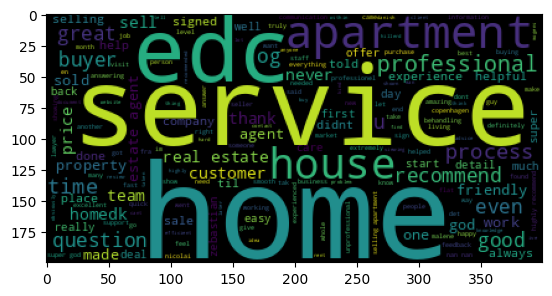

In [20]:
#convert text file in a df into a text corpus
review_meta_text = ' '.join(df['preprocessed_review'])
wc = WordCloud().generate(review_meta_text)
plt.imshow(wc)


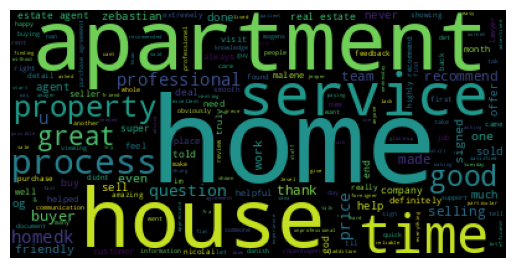

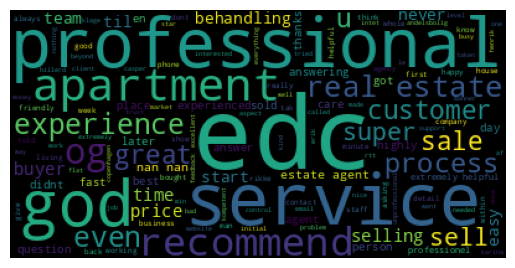

In [21]:
#WordCloud Comparison

def generate_word_cloud (df,company):
  filtered_review = df.loc[df['company']==company,'preprocessed_review'].tolist()
  combined_text = ' '.join(filtered_review)
  wordcloud = WordCloud().generate(combined_text)
  plt.imshow(wordcloud)
  plt.axis('off')
  plt.show()

generate_word_cloud(df,'home')
generate_word_cloud(df,'edc')

2. Sentiment Analysis


In [22]:
#define a function to calculate polarity and subjectivity for a given tweet
def get_sentiment_scores(review):
  analysis=TextBlob(review)
  return analysis.sentiment.polarity, analysis.sentiment.subjectivity

#apply the function to each row of the df and store results in two new columns
df['polarity'], df['subjectivity']=zip(*df['preprocessed_review'].apply(get_sentiment_scores))

#print the first 10 rows of the updated df
df.head(10)

,company,review_title,year,rating,review_text,preprocessed_review,polarity,subjectivity
0,home,God service søde mennesker og super service,2013,5,Home i Glostrup,home glostrup,0.000000,0.000000
1,home,"Home Tårnby - First class, professional servic...",2014,5,Uffe and his team did a great job in both sell...,uffe team great job selling apartment ensuring...,0.453114,0.515320
2,home,Very helpful and quick to answer all questions,2014,5,"Having dealt with another agency, which was ve...",dealt another agency frustrating selling apart...,0.047330,0.670996
3,home,Very professional and well-structured services,2014,5,"My purchase of the own flat (Englandsvej 10, 2...",purchase flat englandsvej tv kbhs well arrange...,0.167667,0.344833
4,home,We looked for a house. Malene at Home.dk helpe...,2014,5,OK. We're not easy folks to please - especial...,ok easy folk please especially come finding ho...,0.305702,0.609474
5,home,Hurtigt og effektivt,2014,5,Home Christianshavn,home christianshavn,0.000000,0.000000
6,home,A really excellent Estate Agent,2015,5,I am a non-Dane buying a Danish property and u...,nondane buying danish property even living cou...,0.312500,0.604167
7,home,Great Support and Experience,2015,5,Stig and his team has been of great support en...,stig team great support end end first purchase...,0.416667,0.461111
8,edc,"I am very satisfied with the whole process, fa...",2015,5,"I have contacted EDC to sell my Andelsbolig, t...",contacted edc sell andelsbolig came directly e...,0.325000,0.492593
9,edc,Solgt etter én uge af et ægte pro: Karina Svær...,2015,5,Solgt etter én uge af et ægte pro: Karina Svær...,solgt etter n uge af et gte pro karina svrrer ...,0.312500,0.537500


In [23]:
#calculate overall polarity and subjectivity
overall_polarity=df['polarity'].mean()
overall_subjectivity=df['subjectivity'].mean()

print(f"Overall polarity: {overall_polarity}")
print(f"Overall subjectivity: {overall_subjectivity}")


Overall polarity: 0.19809779397212085
Overall subjectivity: 0.4013731015151998


In [24]:
#categorize polairty into positive, negative and neurtal
def categorize_polarity (polarity):
  if polarity>0:
    return 'positive'
  elif polarity<0:
    return 'negative'
  else:
    return 'netural'
df['polarity_category']=df['polarity'].apply(categorize_polarity)

#categorize subjectivity into objective and subjective
def categorize_subjectivity (subjectivity):
  if subjectivity>0.5:
    return 'subjective'
  else:
    return 'objective'
df['subjectivity_category']=df['subjectivity'].apply(categorize_subjectivity)

print(df.head(10))

  company                                       review_title  year  rating  \
0    home        God service søde mennesker og super service  2013       5   
1    home  Home Tårnby - First class, professional servic...  2014       5   
2    home     Very helpful and quick to answer all questions  2014       5   
3    home     Very professional and well-structured services  2014       5   
4    home  We looked for a house. Malene at Home.dk helpe...  2014       5   
5    home                               Hurtigt og effektivt  2014       5   
6    home                    A really excellent Estate Agent  2015       5   
7    home                       Great Support and Experience  2015       5   
8     edc  I am very satisfied with the whole process, fa...  2015       5   
9     edc  Solgt etter én uge af et ægte pro: Karina Svær...  2015       5   

                                         review_text  \
0                                    Home i Glostrup   
1  Uffe and his team did a gr

In [25]:
df.to_csv('trustpilot_update.csv',sep=',', index=False, encoding='utf-8')